<a href="https://colab.research.google.com/github/SofiNurul/SKRIPSI/blob/main/Sentiment_Analisis_Produk_Dengan_Algoritma_Naive_Bayes%20FIKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [357]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from wordcloud import WordCloud
import joblib

Mengunduh resource nltk yang diperlukan

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Muat dataset

In [ ]:
df = pd.read_csv('datalatih_ulasanprodukshopee.csv', encoding='MacRoman')

Daftar stopwords dari NLTK dan tambahan khusus Bahasa Indonesia

In [ ]:
stopwords_tambahan = list([
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin'
])

Inisialisasi Lemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

Fungsi untuk membersihkan teks

In [ ]:
def bersihkan_teks(teks):
    if not isinstance(teks, str):
        return ""
    teks = teks.lower()
    teks = re.sub(r'http\S+|www\S+|https\S+', '', teks)
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)
    teks = teks.translate(str.maketrans('', '', string.punctuation))
    teks = re.sub(r'\d+', '', teks)
    kata_kata = teks.split()
    teks_bersih = ' '.join([lemmatizer.lemmatize(kata) for kata in kata_kata if kata not in stopwords_tambahan])
    return teks_bersih

Terapkan fungsi pembersihan pada kolom 'content'

In [ ]:
df['cleaned_content'] = df['content'].apply(bersihkan_teks)

Tampilkan sebagian kecil dari teks yang sudah dibersihkan untuk memastikan hasilnya

In [ ]:
print("Contoh teks setelah pembersihan:")
print(df['cleaned_content'].head(10))

Contoh teks setelah pembersihan:
0    pertama kali coba baca ulasan quora katanya ba...
1    penasaran dari dulu laser bekas luka ilang nem...
2    pke beberapa kali semoga bermanfaat makasih se...
3                                        mudahan cocok
4                                barang sesuai pesanan
5    baru pertama kali coba mudah mudahan pudar bek...
6    baru mau nyoba semoga manjur menghilangkan bek...
7    cottonbud dikasih pelit gimana pake jelas sump...
8    alhamdulillah paketku sudah sampai pesanannya ...
9    dikasih thr sama kakaknya masyaallah berkah se...
Name: cleaned_content, dtype: object


Kamus subjektivitas dengan kategori intensitas dan polaritas emosional

In [ ]:
# Definisikan daftar kata-kata positif dan negatif berdasarkan kamus subjektivitas yang merujuk pada buku 'pengantar metode analisis sentimen'
positif = [
    'pembebasan', 'penghargaan', 'altruistik', 'luar biasa', 'hebat', 'inspiratif', 'bagus',
    'puas', 'baik', 'suka', 'keren', 'bagus sekali', 'cepat', 'efektif', 'cocok', 'manjur',
    'ampuh', 'berhasil', 'kepuasan', 'kekaguman', 'gembira', 'menerima', 'berlimpah', 'makmur',
    'aliansi', 'kondusif', 'sederhana', 'semoga', 'semoga cocok', 'bahagia', 'senang', 'syukur',
    'bersemangat', 'lega', 'bangga', 'optimis', 'prestasi', 'pencapaian', 'menang', 'berkembang',
    'memperbaiki', 'produktif', 'menghargai', 'mengagumi', 'mendukung', 'percaya', 'mencintai',
    'memuji', 'setia', 'nyaman', 'damai', 'tenteram', 'harmonis', 'berkelimpahan', 'dermawan',
    'empati', 'peduli', 'ramah', 'murah hati', 'kebebasan', 'keterbukaan', 'kesempatan', 'harapan',
    'stabil', 'terjamin', 'tenang', 'penyelesaian', 'penyembuhan', 'pemulihan', 'penanggulangan',
    'solusi', 'peningkatan', 'sukses', 'berhasil', 'penuh kasih', 'inovasi', 'berkat', 'semoga berhasil'
]

negatif = [
    'pelecehan', 'kekejian', 'ketakutan', 'kekhawatiran', 'penindasan', 'frustrasi', 'buruk',
    'tidak puas', 'jelek', 'kecewa', 'payah', 'lambat', 'rusak', 'kotor', 'gagal', 'mengecewakan',
    'mahal', 'pecah', 'cuek', 'jutek', 'penyok', 'sampah', 'pelit', 'kurang', 'tidak bermanfaat',
    'bingung', 'parah', 'kurang cocok', 'expired', 'hancur', 'menghapuskan', 'kecanduan',
    'terasing', 'terbatas', 'kekurangan', 'tersendat', 'marah', 'jengkel', 'sedih', 'benci',
    'gelisah', 'stres', 'putus asa', 'gusar', 'penghinaan', 'kekerasan', 'penghinaan', 'bullying',
    'konflik', 'kerugian', 'kebangkrutan', 'kekalahan', 'kerusakan', 'tidak berhasil', 'melemah',
    'terganggu', 'penyalahgunaan', 'terjangkit', 'kritis', 'cacat', 'krisis', 'kemiskinan',
    'pengangguran', 'kesulitan', 'kesusahan', 'hambatan', 'ketidakpercayaan', 'isolasi',
    'permusuhan', 'egois', 'mencemarkan', 'mempersulit', 'membatasi', 'mengurangi', 'mengancam',
    'terpaksa', 'terkekang', 'tertindas', 'terancam', 'tidak berkembang'
]


Fungsi untuk menetapkan sentimen berdasarkan kamus subjektivitas yang digabungkan

In [ ]:
def aturan_sentimen(teks):
    teks = teks.lower()
    if any(kata in teks for kata in positif):
        return 'positive'
    elif any(kata in teks for kata in negatif):
        return 'negative'
    else:
        return 'neutral'

Terapkan aturan sentimen

In [ ]:
df['sentiment'] = df['cleaned_content'].apply(aturan_sentimen)

Pisahkan data menjadi berlabel dan tak berlabel

In [ ]:
df_labeled = df[df['sentiment'].notna()]  # Data berlabel manual (200 data)
df_unlabeled = df[df['sentiment'].isna()]  # Data tanpa label (975 data)

Vektorisasi menggunakan TF-IDF dengan unigram, bigram, dan trigram

In [ ]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_df=0.75,
    min_df=3,
    stop_words=stopwords_tambahan,
    max_features=5000
)
X_labeled = vectorizer.fit_transform(df_labeled['cleaned_content'])
y_labeled = df_labeled['sentiment']

In [ ]:
sample_content = [
    "Ini adalah produk yang bagus dan sangat membantu.",
    "Produk ini jelek dan sangat mengecewakan.",
    "pakek minggu hasilnya bagus bekas luka memudar produknya the best semoga selalu amanah sukses selalu",
    "Sangat mengecewakan, produk tidak sesuai dengan harapan.",
]
vectorizer = TfidfVectorizer()
X_sample = vectorizer.fit_transform(sample_content)

# Ubah hasil TF-IDF menjadi DataFrame agar dapat dilihat
feature_names = vectorizer.get_feature_names_out()
tfidf_sample_df = pd.DataFrame(X_sample.toarray(), columns=feature_names)
print("Hasil TF-IDF untuk data sampel:")
print(tfidf_sample_df)

Hasil TF-IDF untuk data sampel:
     adalah    amanah     bagus     bekas      best       dan    dengan  \
0  0.419606  0.000000  0.330822  0.000000  0.000000  0.330822  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.411010  0.000000   
2  0.000000  0.245281  0.193382  0.245281  0.245281  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.428888   

    harapan  hasilnya       ini  ...    produk  produknya    sangat    selalu  \
0  0.000000  0.000000  0.330822  ...  0.267829   0.000000  0.267829  0.000000   
1  0.000000  0.000000  0.411010  ...  0.332748   0.000000  0.332748  0.000000   
2  0.000000  0.245281  0.000000  ...  0.000000   0.245281  0.000000  0.490562   
3  0.428888  0.000000  0.000000  ...  0.273754   0.000000  0.273754  0.000000   

     semoga    sesuai    sukses       the     tidak      yang  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.419606  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000

Pisahkan data menjadi data latih dan data uji

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.3, random_state=42, stratify=y_labeled)

# **Model : Naive Bayes**

---



Hyperparameter Tuning untuk Model Naive Bayes

In [355]:
param_grid_nb = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='f1_macro')
grid_search_nb.fit(X_train, y_train)
best_nb_model = grid_search_nb.best_estimator_

Simpan Parameter Terbaik dari Grid Search

In [363]:
print("Best Hyperparameters (alpha):", grid_search_nb.best_params_)

Best Hyperparameters (alpha): {'alpha': 0.01}


Cross-Validation untuk Mengecek Stabilitas Model

In [364]:
cv_scores = cross_val_score(best_nb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Akurasi Rata-rata Cross-Validation:", cv_scores.mean())

Akurasi Rata-rata Cross-Validation: 0.7551810790835182


Evaluasi Model

In [365]:
y_pred = best_nb_model.predict(X_test)
print("=== Laporan Klasifikasi ===")
print(classification_report(y_test, y_pred))
print("Akurasi:", accuracy_score(y_test, y_pred))

=== Laporan Klasifikasi ===
              precision    recall  f1-score   support

    negative       0.87      0.71      0.78        28
     neutral       0.64      0.33      0.43        89
    positive       0.77      0.93      0.84       236

    accuracy                           0.76       353
   macro avg       0.76      0.66      0.69       353
weighted avg       0.75      0.76      0.74       353

Akurasi: 0.7620396600566572


Confusion Matrix

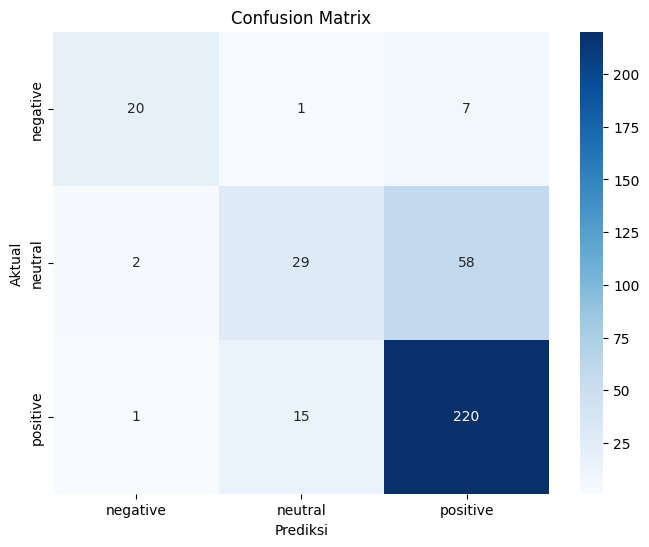

In [360]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_nb_model.classes_, yticklabels=best_nb_model.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

Precision, Recall, dan F1-Score untuk setiap Kelas

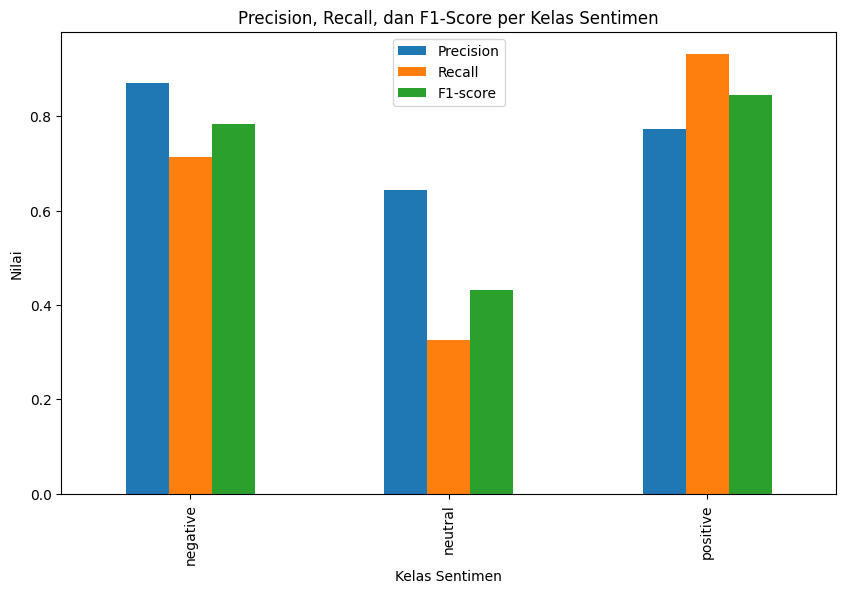

In [361]:
metrics = precision_recall_fscore_support(y_test, y_pred, average=None, labels=best_nb_model.classes_)
metric_df = pd.DataFrame({
    'Kelas Sentimen': best_nb_model.classes_,
    'Precision': metrics[0],
    'Recall': metrics[1],
    'F1-score': metrics[2]
})
metric_df.set_index('Kelas Sentimen').plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall, dan F1-Score per Kelas Sentimen")
plt.ylabel("Nilai")
plt.xlabel("Kelas Sentimen")
plt.show()

Distribusi Sentimen Bar Chart

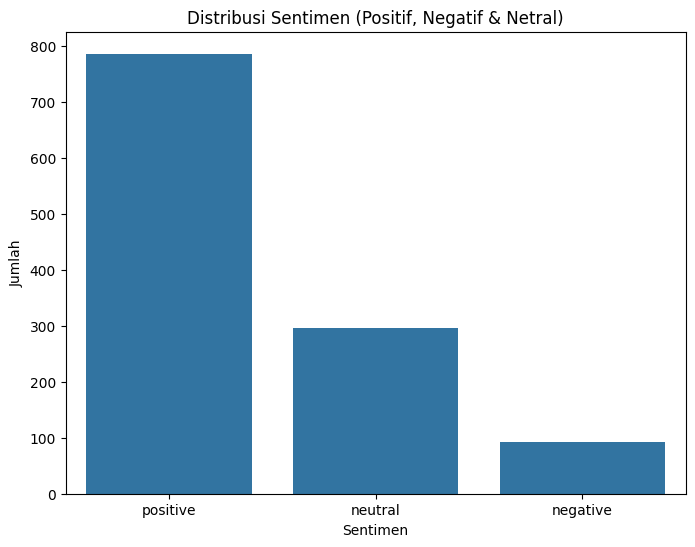

In [362]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Distribusi Sentimen (Positif, Negatif & Netral)')
plt.show()

Distribusi Sentimen Pie Chart

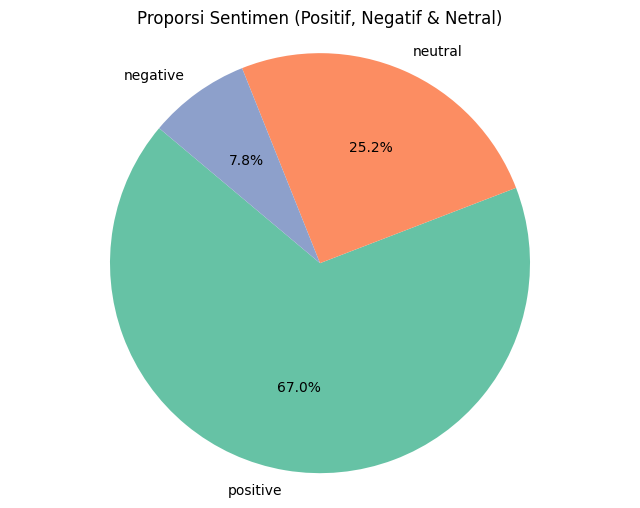

In [350]:
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.axis('equal')  # Agar pie chart menjadi bulat
plt.title('Proporsi Sentimen (Positif, Negatif & Netral)')
plt.show()

Wordcloud untuk ulasan positif

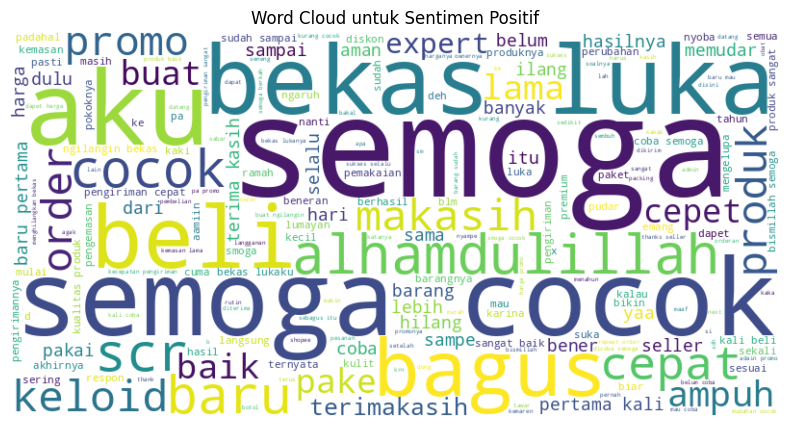

In [351]:
positif_text = ' '.join(df[df['sentiment'] == 'positive']['cleaned_content'])
wordcloud_positif = WordCloud(width=800, height=400, background_color='white').generate(positif_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Positif')
plt.show()

Wordcloud untuk ulasan Negatif

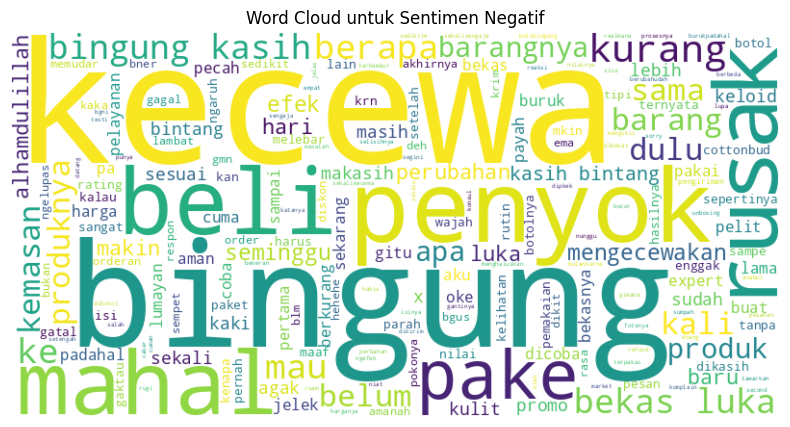

In [352]:
negatif_text = ' '.join(df[df['sentiment'] == 'negative']['cleaned_content'])
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white').generate(negatif_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Negatif')
plt.show()

Wordcloud untuk ulasan netral

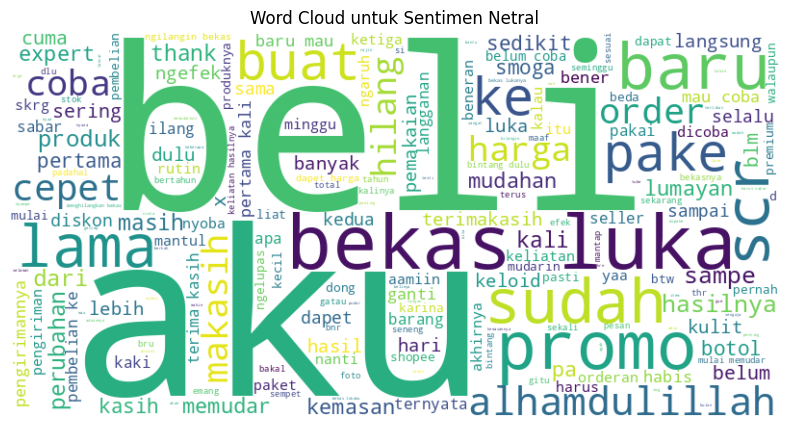

In [353]:
netral_text = ' '.join(df[df['sentiment'] == 'neutral']['cleaned_content'])
wordcloud_netral = WordCloud(width=800, height=400, background_color='white').generate(netral_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Netral')
plt.show()

Bar Plot Kata-Kata yang Paling Sering Muncul

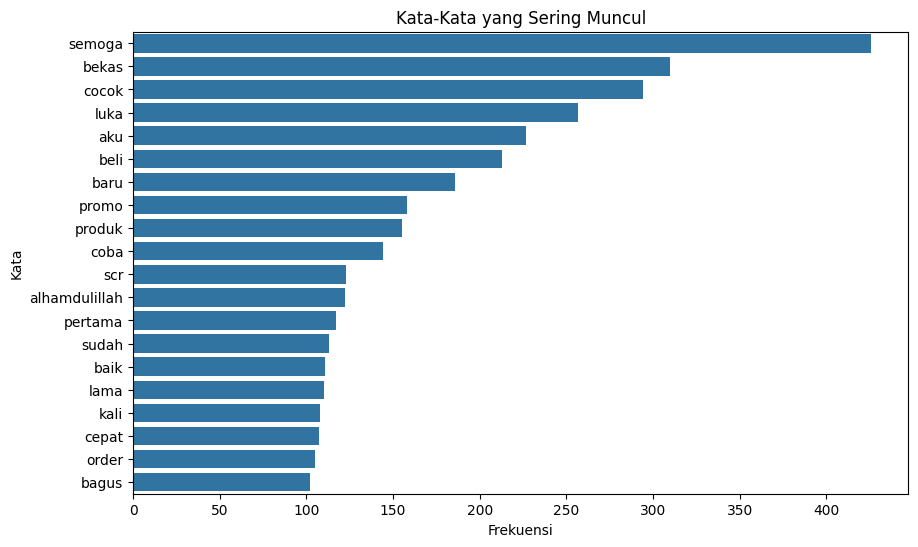

In [354]:
count_vectorizer = CountVectorizer(max_features=20)
word_counts = count_vectorizer.fit_transform(df['cleaned_content'])
word_counts_sum = word_counts.sum(axis=0)
words_freq = [(word, word_counts_sum[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq_df = pd.DataFrame(words_freq, columns=['Kata', 'Frekuensi'])

plt.figure(figsize=(10, 6))
sns.barplot(data=words_freq_df, x='Frekuensi', y='Kata')
plt.title("Kata-Kata yang Sering Muncul")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()

Simpan model dan vectorizer untuk digunakan pada data baru

In [ ]:
joblib.dump(best_nb_model_smote, 'model_naive_bayes_smote.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

Filter data yang belum diberi label (jika ada)

In [ ]:
df_unlabeled = df[df['sentiment'].isna()]

Periksa apakah ada data tanpa label sebelum melakukan transformasi dan prediksi

In [ ]:
if not df_unlabeled.empty:
    X_unlabeled = vectorizer.transform(df_unlabeled['cleaned_content'])
    df_unlabeled['predicted_sentiment'] = best_nb_model.predict(X_unlabeled)
    # Gabungkan data berlabel dan data yang diprediksi
    df_final = pd.concat([df, df_unlabeled], ignore_index=True)
else:
    print("Tidak ada data tanpa label yang perlu diprediksi.")
    df_final = df  # Jika tidak ada data tanpa label, langsung gunakan data asli

Tidak ada data tanpa label yang perlu diprediksi.


Simpan hasil prediksi ke file CSV

In [366]:
df_final.to_csv('hasil_prediksi_sentimen_naivebayes.csv', index=False)
print("Hasil prediksi sentimen telah disimpan dalam file 'hasil_prediksi_sentimen_naivebayes.csv'.")

Hasil prediksi sentimen telah disimpan dalam file 'hasil_prediksi_sentimen_naivebayes.csv'.
